In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA  
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression


In [125]:
data = pd.read_csv("/Users/seydanurkayir/Desktop/iyzico-datathon/train.csv")
data.head()

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
0,merchant_43992,202307,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,15106
1,merchant_43992,202301,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16918
2,merchant_43992,202305,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,13452
3,merchant_43992,202308,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16787
4,merchant_43992,202302,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,12428


In [126]:
data[["Merchant", "ID"]] = data["merchant_id"].str.split("_", expand=True)
train = data.drop(['merchant_source_name','settlement_period',
                      'working_type','mcc_id','merchant_segment','Merchant','merchant_id'], axis=1)
train = train.sort_values(by=[ 'ID','month_id'])

train.head()

,month_id,net_payment_count,ID
234370,202108,3,1
234371,202210,3,1
249229,202111,6,10
249226,202112,24,10
249224,202201,15,10


In [127]:
train["month_id"] = pd.to_datetime(train["month_id"], format="%Y%m")
train = train.sort_values(by=[ 'month_id'])
train.head()

,month_id,net_payment_count,ID
39020,2020-01-01,5,48325
100041,2020-01-01,3,15886
86856,2020-01-01,22,31247
81952,2020-01-01,14,67022
103759,2020-01-01,8,24293


In [128]:
#--> ADF TESTİ YAPILAMAYACAK KADAR AZ VERİ VAR İSE REGRESYON İLE TAHMİN YAPTIR 

In [129]:
def test_adfuller(train,id):
    data = train[train['ID'] == id]
    merchant_data = data.sort_values(by='month_id')
    ts_log = np.log(merchant_data['net_payment_count'])

    if len(ts_log) > 9 :
        res = adfuller(ts_log)
        if res[1] <= 0.05:
            print(f"ID {id}  is stationary.")
        else:
            print(f"ID {id} is not stationary")
    else:
        print(f"ID {id} is not stationary")

test_adfuller(train,'10059')


ID 10059 is not stationary


In [130]:
#DURAĞAN OLMAYAN ID'LER
def diff_test_adfuller(train, id):
    data = train[train['ID'] == id]
    merchant_data = data.sort_values(by='month_id')
    ts_log = np.log(merchant_data['net_payment_count'])
    ts_log_diff_1 = ts_log - ts_log.shift()
    ts_log_diff_1.dropna(inplace=True)

    if len(ts_log_diff_1) > 10:  
        res = adfuller(ts_log_diff_1, autolag='AIC')
        print(f"Length of differenced series: {len(ts_log_diff_1)}")

        if res[1] <= 0.05:
            print(f"ID {id} is stationary.")

        else:
            ts_log_diff_2 = ts_log_diff_1 - ts_log_diff_1.shift()
            ts_log_diff_2.dropna(inplace=True)

            if len(ts_log_diff_2) >= 1:  
                ts_log_diff_2 = ts_log_diff_2.iloc[1:]
                res2 = adfuller(ts_log_diff_2, autolag='AIC')
                print(f"Length of differenced series: {len(ts_log_diff_2)}")

                if res2[1] <= 0.05:
                    print(f"ID {id} is stationary.")

                else:
                    print(f"ID {id} is not stationary.")

            else:
                print(f"ID {id} differenced series has zero or negative length for the ADF test.")
                
    else:
        print(f"ID {id} differenced series is too short for the ADF test.")

diff_test_adfuller(train, '10059')


ID 10059 differenced series is too short for the ADF test.


In [131]:
data = train[train['ID'] == '10059']
merchant_data = data.sort_values(by=['month_id'])


In [132]:
X = merchant_data['month_id']  
y = merchant_data['net_payment_count']

In [133]:
train['month_id'] = pd.to_datetime(train['month_id'], format='%Y-%m')


Forecast for Merchant ID 10059:

            Forecast
2023-10-01       9.5
2023-11-01       9.5
2023-12-01       9.5


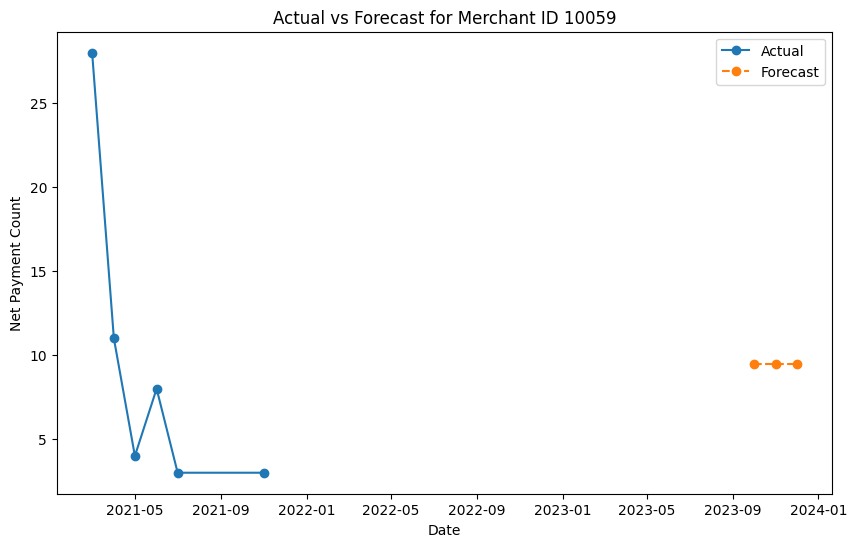

In [134]:
def regression_analysis(train, id, forecast_start_date=None, forecast_periods=3):
    data = train[train['ID'] == id]
    merchant_data = data.sort_values(by='month_id')

    X = merchant_data['ID'].values.reshape(-1, 1)
    y = merchant_data['net_payment_count']

    model = LinearRegression()
    model.fit(X, y)

    if forecast_start_date is None:
        forecast_start = merchant_data['month_id'].max()
        
    else:
        forecast_start = pd.to_datetime(forecast_start_date)

    forecast_index = pd.date_range(start=forecast_start, periods=forecast_periods, freq='MS')
    
    forecast_X = pd.to_datetime(np.arange(len(X), len(X) + forecast_periods), unit='D', origin=pd.Timestamp("1970-01-01"))
    forecast_X = forecast_X.values.reshape(-1, 1).astype(int)  
    
    forecast_values = model.predict(forecast_X)

    forecast_df = pd.DataFrame({
        'Forecast': forecast_values,
    }, index=forecast_index)

    print(f"Forecast for Merchant ID {id}:\n")
    print(forecast_df)
    plt.figure(figsize=(10, 6))
    plt.plot(merchant_data['month_id'], merchant_data['net_payment_count'], label='Actual', marker='o')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', linestyle='--', marker='o')
    plt.title(f"Actual vs Forecast for Merchant ID {id}")
    plt.xlabel("Date")
    plt.ylabel("Net Payment Count")
    plt.legend()
    plt.show()

regression_analysis(train, '10059', forecast_start_date='2023-10-01', forecast_periods=3)


#--> ADF TESTİNDE SONUÇ DURAĞAN VAR İSE MODELLE VE TAHMİN YAPILIR.


In [135]:
train['month_id'] = train['month_id'].astype('datetime64[ns]')
train.set_index('month_id', inplace=True)


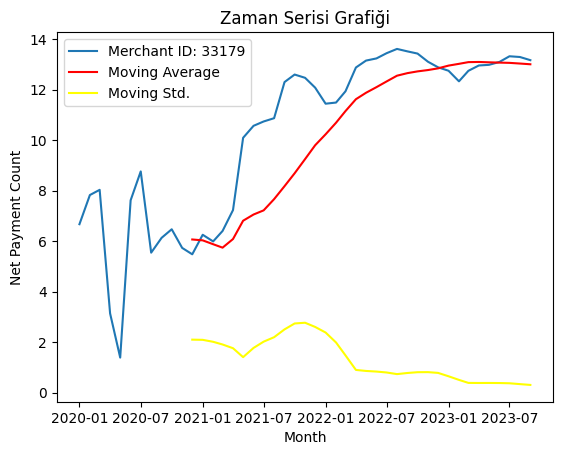

In [136]:
def plot_merchant(train, id):
    data = train[train['ID'] == id]
    merchant_data = data.sort_values(by=['month_id'])
    
    ts_log = np.log(merchant_data['net_payment_count'])
    moving_avg = ts_log.rolling(12).mean()
    moving_std = ts_log.rolling(12).std()

    plt.plot(ts_log, label=f'Merchant ID: {id}')
    plt.plot(moving_avg, color='red', label='Moving Average')
    plt.plot(moving_std, color='yellow', label='Moving Std.')

    plt.legend()
    plt.xlabel('Month')
    plt.ylabel('Net Payment Count')
    plt.title('Zaman Serisi Grafiği')

    plt.show()


plot_merchant(train,'33179')

In [137]:

merchant_data = train[train['ID'] == '33179']

data = merchant_data['net_payment_count']
ts_log = np.log(merchant_data['net_payment_count'])


model = pm.auto_arima(ts_log, 
                      m=12,                                  
                      seasonal=True,  
                      d=1,            
                      test='adf',         
                      start_p=0, start_q=0, 
                      max_p=3, max_q=3,   
                      D=None,             
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=165.503, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=162.063, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=165.699, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=161.081, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=160.512, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=163.753, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=163.643, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=164.013, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=159.592, Time=0.09 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=161.149, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=163.050, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=158.291, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=159.972, Time=0.08 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=159.912, Time=0.07 sec
 ARIMA(1,1,1)(1,0,1)[12] intercep

In [138]:
data = train[train['ID'] == '33179']
merchant_data = data.sort_values(by=['month_id'])
ts_log = np.log(merchant_data['net_payment_count'])

model = sm.tsa.ARIMA(ts_log, order=(2, 1, 1))  

results_ARIMA = model.fit()
forecast_periods = 3

forecast = results_ARIMA.get_forecast(steps=forecast_periods)

forecast_index = pd.date_range(start=ts_log.index[-1], periods=forecast_periods+1, freq='MS')[1:]

forecast_values = np.exp(forecast.predicted_mean)

forecast_df = pd.DataFrame({
    'Forecast': forecast_values,
}, index=forecast_index)

print(f"Forecast for Merchant ID :{'33179'}\n")
print(forecast_df)


Forecast for Merchant ID :33179

                 Forecast
2023-10-01  543291.471902
2023-11-01  581395.709094
2023-12-01  561118.250807


/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/seydanurkayir/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


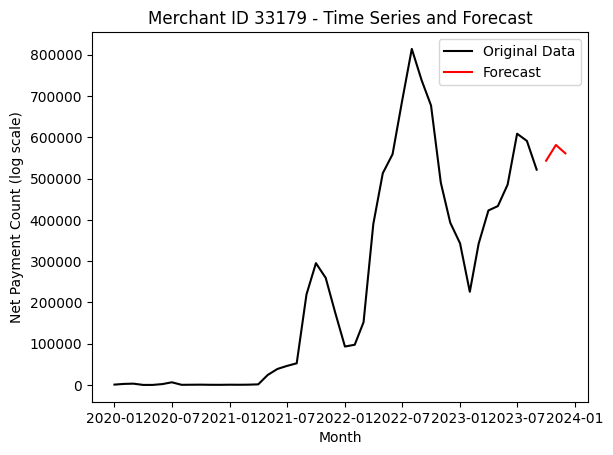

In [139]:
plt.plot(merchant_data.index, merchant_data['net_payment_count'], label='Original Data', color='black')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')

plt.title('Merchant ID 33179 - Time Series and Forecast')
plt.xlabel('Month')
plt.ylabel('Net Payment Count (log scale)')
plt.legend()
plt.show()
